# Model Implementation Testing

By Nida Copty, India Tory, Emily Nguyen, Thomas Nguyen

This notebook marks the culmination of our efforts in constructing LSTM models to forecast homeless shelter occupancy rates in Toronto. It represents the final installment in the LSTM series developed by the Compassionate Coders team.

Across the preceding three notebooks, we've meticulously crafted four distinct LSTM implementations tailored to this project's objectives. In this concluding script, we shift our focus to rigorous testing, aiming to discern each model's performance under various conditions.

Through comprehensive evaluation, we aim to identify the most effective model for forecasting homeless shelter occupancy rates. This script serves as the project's showcase, showcasing the strengths and capabilities of our LSTM implementations.

### Imports

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import random
import seaborn as sns
from itertools import combinations

### Dataset Load

In [2]:
#Occupancy Rate (Output Data):
data_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv"
data_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv"
data_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv"
data_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv"
links = [data_24, data_23, data_22, data_21]

#Weather Data
data_w_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv"
data_w_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv"
data_w_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2022_P1D.csv"
data_w_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2021_P1D.csv"
links_weather = [data_w_24, data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Housing.csv"

#Crisis helpline
data_crisis = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv"

class to read and report on errors when reading csv files.

In [3]:
def load_csv_to_pandas(file_path):
    try:
        # Load CSV file into a pandas dataFrame
        df = pd.read_csv(file_path, header=0, low_memory=False, encoding='unicode_escape')
        print("Number of rows in the dataFrame:", file_path, len(df))
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

This function below is to convert all the datasets of different features into a singular panda dataframes and also a hashmap containing individual shelter datas.

In [4]:
def loadData(output_data, weather_data, housing, crisis):

    #-------Output Data-------#
    #Loading up the links to the output dataset
    for i in range(len(output_data)):
        output_data[i] = load_csv_to_pandas(output_data[i])

    #Dropping irrelevant columns for output datasets
    for i in range(len(output_data)):
        #print(output_data[i])
        output_data[i] = output_data[i].drop(columns = ['_id', 'SHELTER_ID', 'LOCATION_ID', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_FUNDING_BED', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_FUNDING_ROOM', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS'])
        output_data[i]['OCCUPANCY_DATE'] = output_data[i]['OCCUPANCY_DATE']
        output_data[i]['OCCUPANCY_DATE'] =  pd.to_datetime(output_data[i]['OCCUPANCY_DATE'], format='%Y-%m-%d')

    #Joining the Output data together
    big_data = output_data[0]
    for i in range(1,len(output_data)):
        big_data = pd.concat([big_data, output_data[i]], ignore_index = True)

    #Determine the max and min date in the dataset to create a date vector to fill out empty values
    max_date = big_data['OCCUPANCY_DATE'].max()
    min_date = big_data['OCCUPANCY_DATE'].min()
    date_range = pd.date_range(start=min_date, end=max_date, freq = 'D')
    date_df = pd.DataFrame({'OCCUPANCY_DATE': date_range})

    #-------Weather Data-------#

    #loading up the links to the weather dataset
    for i in range(len(weather_data)):
        weather_data[i] = load_csv_to_pandas(weather_data[i])

    #Dropping irrelevant columns for weather datasets
    for i in range(len(weather_data)):
        weather_data[i] = weather_data[i].drop(columns = ['ï»¿"Longitude (x)"', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag',
        'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'])
        weather_data[i]['Date/Time'] = weather_data[i]['Date/Time'].astype(str)
        weather_data[i]['Date/Time'] = pd.to_datetime(weather_data[i]['Date/Time'])

    #Joining the Weather data together
    big_weather = weather_data[0]
    for i in range(1, len(weather_data)):
        big_weather = pd.concat([big_weather, weather_data[i]], ignore_index = True)

    #Cut down all data with dates that is bigger than the biggest date and smaller than the smallest date with an output
    big_weather = big_weather[big_weather['Date/Time'] <= max_date]
    big_weather = big_weather[big_weather['Date/Time'] >= min_date]

    #Fill out datasets' entries w no data w 0
    big_weather = big_weather.fillna(0)

    #Changing non output dataset's date column to 'OCCUPANCY_DATE'
    big_weather = big_weather.rename(columns = {'Date/Time': 'OCCUPANCY_DATE'})

    #-------Housing Data-------#

    #loading up housing data
    housing = load_csv_to_pandas(housing)

    #Dropping irrelevant columns for housing dataset
    housing = housing[housing['GEO'] == 'Toronto, Ontario']
    housing = housing[housing['New housing price indexes'] == 'Total (house and land)']
    housing = housing.drop(columns = ['GEO', 'DGUID', 'New housing price indexes', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'])
    housing = housing.rename(columns = {housing.columns[0]: 'OCCUPANCY_DATE'})
    housing["OCCUPANCY_DATE"] = pd.to_datetime(housing["OCCUPANCY_DATE"])
    housing = housing[housing["OCCUPANCY_DATE"] >= min_date]
    housing = housing[housing["OCCUPANCY_DATE"] <= max_date].reset_index(drop=True)
    housing = pd.merge(housing, date_df, on = 'OCCUPANCY_DATE', how = 'outer')
    housing = housing.sort_values(by='OCCUPANCY_DATE').reset_index(drop=True)
    housing = housing.ffill()

    #-------Crisis Data-------#

    #Loading the crisis dataset
    crisis = load_csv_to_pandas(crisis)

    #Analyize Data
    crisis = crisis.drop(columns = ['ï»¿OBJECTID', 'EVENT_ID', 'EVENT_YEAR', 'EVENT_MONTH', 'EVENT_DOW', 'EVENT_HOUR', 'DIVISION', 'OCCURRENCE_CREATED', 'APPREHENSION_MADE', 'MCIT_ATTEND', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140'])
    crisis = crisis.rename(columns = {'EVENT_DATE': 'OCCUPANCY_DATE'})
    crisis = crisis.groupby(['OCCUPANCY_DATE', 'EVENT_TYPE']).size().unstack(fill_value=0)
    crisis.reset_index(inplace=True)
    crisis = crisis.rename_axis(None, axis=1)
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE']).dt.date
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE'])
    crisis = crisis[crisis["OCCUPANCY_DATE"] >= min_date]
    crisis = crisis[crisis["OCCUPANCY_DATE"] <= max_date]
    crisis = pd.merge(date_df, crisis, on='OCCUPANCY_DATE', how='left')

    #-------Final Data Prep-------#

    #Merge the datasets together through date
    big_data = pd.merge(big_data, big_weather, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, housing, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, crisis, on = 'OCCUPANCY_DATE', how = 'inner')

    big_data = big_data.sort_values(by='OCCUPANCY_DATE')

    #Placing the bed and room occupancy column last
    room_occupancy = big_data.pop('OCCUPANCY_RATE_ROOMS')
    bed_occupancy = big_data.pop('OCCUPANCY_RATE_BEDS')
    big_data['OCCUPANCY_RATE_BEDS'] = bed_occupancy
    big_data['OCCUPANCY_RATE_ROOMS'] = room_occupancy

    grouped_data = big_data.groupby('PROGRAM_ID')
    shelter_data_frames = {}
    for shelter_id, shelter_group in grouped_data:
        shelter_data_frames[shelter_id] = shelter_group
        shelter_data_frames[shelter_id]['OCCUPANCY_DATE'] = pd.to_datetime(shelter_data_frames[shelter_id]['OCCUPANCY_DATE'])

    big_data.reset_index(inplace=True)
    big_data = big_data.drop(columns = ['index'])

    return big_data, shelter_data_frames

The dataframe above contains every single data points of every shelters from 2021 to 2024. Inorder to get a trainable dataset for the combined shelter data multivariate model, we will have to combine the data of everysingle shelters together into one big city wide occupancy rates. This function below will achieve that target.

In [5]:
def merge_Shelters_Data(df):
    df = df.drop(columns = ['ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'SECTOR', 'ORGANIZATION_ID', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE' ,'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'PROGRAM_ID', 'CAPACITY_TYPE', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'])
    grouped_capacity = df.groupby('OCCUPANCY_DATE')[['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM']].sum()
    grouped_occupied = df.groupby('OCCUPANCY_DATE')[['OCCUPIED_BEDS', 'OCCUPIED_ROOMS']].sum()

    df = df.merge(grouped_capacity, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_CAPACITY'))
    df = df.merge(grouped_occupied, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_OCCUPIED'))
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM', 'OCCUPIED_BEDS', 'OCCUPIED_ROOMS'])
    df = df.drop_duplicates()

    df['TOTAL_OCCUPIED'] = df['OCCUPIED_BEDS_TOTAL_OCCUPIED'] + df['OCCUPIED_ROOMS_TOTAL_OCCUPIED']
    df['TOTAL_CAPACITY'] = df['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY'] + df['CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY']
    df['OCCUPIED_PERCENTAGE'] = 100 * df['TOTAL_OCCUPIED']/df['TOTAL_CAPACITY']
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY', 'CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY', 'OCCUPIED_BEDS_TOTAL_OCCUPIED', 'OCCUPIED_ROOMS_TOTAL_OCCUPIED', 'TOTAL_CAPACITY', 'TOTAL_OCCUPIED'])
    return df

Running the function to get the dataframe and hashmap

In [6]:
dataframe, iso_data = loadData(links.copy(), links_weather.copy(), data_housing, data_crisis)

Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv 11459
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv 48345
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv 49478
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv 50944
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv 366
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv 365
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI 

### Convert Dataset to DataLoader

With the proper dataframe, we will need to convert the dataset into a timeseries and then dataloader to feed into the model for training

This function below is to grab the scaler to scale the dataset

In [7]:
def get_scaler():
    scaler = MinMaxScaler(feature_range = (-1, 1))
    return scaler

Differing than the Univariate, we will have to check if all features have all of their values filled in. If not we must manually fill it in by taking the average of the existing data. The function below accomplishes that.

In [8]:
def feature_check(df):
    df_ = dc(df)
    for i in df_.columns:
        if df_[i].isna().any():
            avg = df_[i].mean()
            df_.loc[:, i] = df_[i].fillna(avg)
    return df_

To Convert the dataset into a dataloader, we will need to define a Dataset class for the time series

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

This function below will convert the dataframe to a time series for the model with proper hyperparameters as inputs

In [10]:
def time_series_converter(iso_data, scaler, n_past, n_future, train_test_split, batch_size, used_features, shel_group = None):

    train_x = []
    train_y = []

    if shel_group is not None:

        one_hot_len = max(shel_group.values()) + 1

        num_feat = len(used_features) - 1 + one_hot_len

        dfs = []

        #Iterate through all useable Shelters
        for i in shel_group:

            #Getting the df from Iso Data
            df = dc(iso_data[int(i)])

            #Unifying the df to have the same output column name
            if df['OCCUPANCY_RATE_ROOMS'].isna().all():
                df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
            else:
                df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

            df = df[used_features]

            df = feature_check(df)

            for z in range(one_hot_len):
                if shel_group[i] == z:
                    df['Feature_' + str(z)] = 1
                else:
                    df['Feature_' + str(z)] = 0

            dfs.append(df)

            #Concatenating all Dfs together
            concatenated_df = pd.concat(dfs, ignore_index=True)

            #Isolate the feature columns
            iso_col = concatenated_df[['Feature_' + str(i) for i in range(one_hot_len)]]

            #Scaled the dfs
            scaler = scaler.fit(concatenated_df[used_features[1:]])
            np_df = scaler.fit_transform(concatenated_df[used_features[1:]])
            df_scaled = pd.DataFrame(np_df, columns=used_features[1:])

            #Combined the final df together
            np_df = pd.concat([iso_col, df_scaled], axis=1).values

    else:
        df = dc(iso_data)
        df.set_index('OCCUPANCY_DATE', inplace=True)
        df = df.astype(float)
        scaler = scaler.fit(df)

        np_df = scaler.transform(df)

        num_feat = len([i for i in df])

    #Converting it into a time series
    for i in range(n_past, len(np_df) - n_future + 1):
        train_x.append(np_df[i - n_past: i, 0:np_df.shape[1]])
        train_y.append(np_df[i: i + n_future, - 1])

    train_x, train_y = np.array(train_x), np.array(train_y)

    split_index = int(len(train_x) * train_test_split)

    X_train = train_x[:split_index]
    X_test = train_x[split_index:]

    Y_train = train_y[:split_index]
    Y_test = train_y[split_index:]

    X_train_ = X_train.reshape((-1, n_past, num_feat))
    X_test_ = X_test.reshape((-1, n_past, num_feat))

    X_train = torch.tensor(X_train).float()
    Y_train = torch.tensor(Y_train).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()

    train_Dataset = TimeSeriesDataset(X_train, Y_train)
    test_Dataset = TimeSeriesDataset(X_test, Y_test)

    train_loader = DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_Dataset, batch_size = batch_size, shuffle = False)

    return train_loader, test_loader

### Define the Model

Before training can begin, we will have to define the model architecture. Since the model is an lstm, it will contain LSTM architectures and also fully connected layers for the final output result. Please see the infrastructure below:

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layers
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(1, num_stacked_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        # Define the fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size)])
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size = x.size(0)
        out = x

        # Initialize hidden state and cell state tensors for each LSTM layer
        hidden_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]
        cell_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]

        # Pass input through each LSTM layer
        for lstm_layer, h0, c0 in zip(self.lstm_layers, hidden_states, cell_states):
            out, _ = lstm_layer(out)

        # Apply fully connected layers
        out = self.fc_layers[0](out[:, -1, :])  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation function
        for fc_layer in self.fc_layers[1:]:
            out = fc_layer(out)

        return out

Model Training Function. Call this function and pass in the model to begin training.

In [12]:
def begin_training(model,num_epochs, train_loader, test_loader, loss, optimizer, device):

    training_loss = []
    validation_loss = []
    average_validation_loss = []
    for epoch in range(num_epochs):

        #Training
        model.train(True)
        running_loss = 0
        if epoch % 5 == 0:
          print("Epoch: " + str(epoch + 5))

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output        = model(x_batch).to(device)
            loss_         = loss(output, y_batch)
            running_loss += loss_.item()

            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        if epoch % 5 == 0:
          print("Training Loss: " + str(running_loss))
        training_loss.append(running_loss)

        #Validating
        model.train(False)
        vad_loss = 0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            with torch.no_grad():
                output    = model(x_batch).to(device)
                loss_     = loss(output, y_batch)
                vad_loss += loss_.item()

        validation_loss.append(vad_loss)
        avg_loss_across_batches = vad_loss / len(test_loader)
        average_validation_loss.append(avg_loss_across_batches)
        if epoch % 5 == 0:
          print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
          print('***************************************************')
          print('\n')


    return model, training_loss, validation_loss, average_validation_loss

This function below randomized the weights of the model. This function is to make sure the model is properly initialized while testing.

In [13]:
def reset_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module.reset_parameters()

### Testing Commences

Since the multivariate models that uses one hot encoded grouping are trained on only 62 viable shelters, the rest of the shelters will be eliminated from testing.

In [14]:
viable_shelters = [11794, 11798, 11799, 11815, 11831, 11871, 11891, 11895, 11911, 11971, 12011, 12053, 12231, 12251, 12252, 12254, 12274, 12291, 12292, 12471, 12711, 13451, 13932, 14051, 14251, 14571, 14572, 14631, 14651, 14671, 14931, 15111, 15112, 15171, 15711, 15811, 15871, 16111, 16131, 16151, 16191, 16192, 16193, 16194, 16271, 16311, 16371, 16671, 16691, 16891, 16892, 16911, 17011, 17012, 17191, 17211, 17212, 17691, 17771, 17772, 17791, 17811]
for i in iso_data.copy():
  if i not in viable_shelters:
    del iso_data[i]

For testing purposes, we will only be comparing our accuracy with these 5 shelters: 11794, 11831, 11252, 11254, 11274

In [15]:
test_shelters = [11794, 11831, 12252, 12254, 12274]
test_data = iso_data.copy()
for i in test_data.copy():
  if i not in test_shelters:
    del test_data[i]

We will also need to use the model to infer future dates to calculate their performance. The function below achieves that.

In [16]:
def infer_date_(model, df, scaler, n_future, future_days = None, one_hot_feature = None):

    #one_hot_feature guide
    #0: Index of 1's
    #1: Length of Vector

    #Set model training to False
    model.train(False)
    copy_df = dc(df)

    #Case 1: if model predicts multiple days at once
    if n_future > 1:

        #Build Dateframe for future days
        max_date = df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date, end=max_date + pd.Timedelta(days=n_future), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Scaling input Dataframe
        copy_df.set_index('OCCUPANCY_DATE', inplace = True)
        df_scaled = scaler.fit_transform(copy_df)

        if one_hot_feature is not None:
            for i in range(one_hot_feature[1]):

                if i != one_hot_feature[0]:
                    arr = np.zeros((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))
                else:
                    arr = np.ones((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))

        #Convert data to tensor and passing it into the model to get predicted data and converting it into a panda dataframe before returning it
        input_data = torch.tensor(df_scaled).unsqueeze(0).float().to(device)
        y = model(input_data).detach().cpu().numpy().reshape(-1, 1)
        y_ = np.repeat(y, copy_df.shape[1], axis = -1)
        y_actual = scaler.inverse_transform(y_)[:,-1]
        y_inserted = np.insert(y_actual, 0, df['OCCUPIED_PERCENTAGE'].iloc[-1])
        df_new['OCCUPIED_PERCENTAGE'] = pd.DataFrame(y_inserted, columns = ['OCCUPIED_PERCENTAGE'])


    #Case 2: if model predicts one day at a time; therefore need loop to predict all future_days days.
    if n_future == 1 and future_days is not None:

        data = torch.tensor(scaler.fit_transform(np.array(copy_df['OCCUPIED_PERCENTAGE']).reshape(-1, 1)).reshape((-1, copy_df.shape[0], 1))).float()
        for i in range(future_days):
            y = model(data).unsqueeze(0)
            data = torch.cat((data, y), dim = 1)
        data = scaler.inverse_transform(data.squeeze().detach().numpy().reshape(-1, 1)).flatten()

        #Adding a data column to the new data
        max_date = copy_df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date , end=max_date + pd.Timedelta(days=future_days), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Getting the newly generated portion of data
        new_data = data[-future_days:]
        new_data = np.insert(new_data, 0, copy_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        new_data_df = pd.DataFrame(new_data, columns = ['OCCUPIED_PERCENTAGE'])

        #Combined
        df_new['OCCUPIED_PERCENTAGE'] = new_data_df

    return df_new

For each feature set that we test on, we will ask each model implementation to infer data for every single viable individual shelter and calculate the average loss for each model. The function below will take the model and iterate through all individual shelter to find the average loss.

In [17]:
def calc_loss(model, iso_data, used_features, shel_grouping = None, adj_factors = None):
  #Initialize the Loss variables
  total_shel = 0
  loss_ = 0

  total_shel_ = 0
  loss_sq = 0

  for i in iso_data:

    if len(iso_data[i]) > 60:
      df = iso_data[i]

      #Rename the columns
      if df['OCCUPANCY_RATE_ROOMS'].isna().all():
        df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
      else:
        df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})


      df_mult = df.copy()

      #Selecting on used features
      df = df[used_features]

      df = feature_check(df)

      #Move the dates back by 60 days
      df_use_infer = dc(df)
      use_date = max(df_use_infer['OCCUPANCY_DATE']) - pd.Timedelta(days = 60)
      df_use_infer = df_use_infer[df_use_infer['OCCUPANCY_DATE'] <= use_date]

      #Inferring Data
      if shel_grouping is None:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = None)
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]
      else:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = [shel_grouping[i], max(shel_grouping.values()) + 1])
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]

      #Obtain and apply the multiplying factor
      if adj_factors is not None:
        mult = multiplying_factor(df_infer, df_mult, adj_factors)
        df_infer['OCCUPIED_PERCENTAGE'] *= mult

      #data used for loss calculations
      df_loss = dc(df)
      df_loss = df_loss[df_loss['OCCUPANCY_DATE'] > use_date]

      #Calculating Loss
      df_np = df_loss['OCCUPIED_PERCENTAGE'].values
      df_np_infer = df_infer['OCCUPIED_PERCENTAGE'].values

      temp_loss = 0
      temp_loss_sq = 0
      for i in range(len(df_np)):
        temp_loss += abs(df_np[i] - df_np_infer[i])
        temp_loss_sq += abs(df_np[i] - df_np_infer[i]) ** 2
      if temp_loss > 0:
        total_shel += 1
        loss_ += temp_loss
      if temp_loss_sq > 0:
        total_shel_ += 1
        loss_sq += temp_loss_sq
      loss_ /= 60
      loss_sq /= 60
      loss_sq = loss_sq ** (1/2)


  avg_loss = loss_/total_shel
  avg_loss_sq = loss_sq/total_shel_
  return avg_loss, avg_loss_sq

Function for adjustment factors in the two steps process

In [18]:
def calculate_adjustment_factors(dataset, city_predictions_df, feature):
  '''
  INPUTS:
  dataset (DataFrame): This should include the entire dataset including predictions for each row. The dataset should include
  the actual occupancy rate, column named 'OCCUPANCY_RATE'. The prediction column should be named 'CITY_PREDICTIONS'.

  feature (String): The name of the feature. This feature should be in the dataset.

  OUTPUT:
  average_difference_by_feature (DataFrame): has two columns. One of them is named <feature> and has every category of that feature
  (e.g. each sector type). The second column, named 'PERCENT_DIFF' contains the adjustment factors (percent devaition from the mean for each category)
  '''
  # Data Prep

  dataset_prep = dataset

  dataset_prep['DAY_OF_WEEK'] = dataset_prep['OCCUPANCY_DATE'].dt.dayofweek
  dataset_prep['MONTH'] = dataset_prep['OCCUPANCY_DATE'].dt.month

  dataset_prep = dataset_prep.groupby([feature, 'OCCUPANCY_DATE']).agg({
      'OCCUPANCY_RATE': 'mean',
      'DAY_OF_WEEK': 'first',  # since all entries per day should be the same
      'MONTH': 'first'
  }).reset_index()

  dataset_prep = pd.merge(dataset_prep, city_predictions_df, on = 'OCCUPANCY_DATE', how='left')


  dataset_with_percent_diff = pd.DataFrame()
  dataset_with_percent_diff['PERCENT_DIFF'] = ((dataset_prep['OCCUPANCY_RATE'] - dataset_prep['CITY_PREDICTIONS']) / dataset_prep['CITY_PREDICTIONS']) * 100
  dataset_with_percent_diff = pd.concat([dataset_with_percent_diff, dataset_prep], axis=1)
  average_difference_by_feature = dataset_with_percent_diff.groupby(feature)['PERCENT_DIFF'].mean().reset_index()
  return average_difference_by_feature

Before we run the loop to find the test again, we also need to define the function that will calculate the multiplying factor for our prediction from the adjustment factors

In [19]:
def multiplying_factor(pred, shel ,adj_factors):
  mult = 1
  for i in adj_factors:
    adj =  (100 + float(adj_factors[i][adj_factors[i][i] == shel[i].iloc[0]]['PERCENT_DIFF'].iloc[0])) / 100
    mult *= adj
  return mult

Define Model's Hyperparameters

In [20]:
n_steps = 90
n_future = 60
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()
learning_rate = 1e-3
num_epochs = 20
train_test_split = 0.8
loss_function = nn.MSELoss()
hidden_size = 120
num_stacked_layers = 3
output_size = n_future

Extract a list of all trainable features for testing.

In [21]:
total_features = ['Snow on Grnd (cm)', 'Max Temp (Â°C)', 'Min Temp (Â°C)'] # With 'VALUE'

Loop to iterate through every combinations of trainable features inorder to test their effect on different Model's implementation.

In [23]:
#Hashmap to store the result of each model with each feature set
result_map = {}

device = torch.device("cpu")

#unify citywide output
copy_df = dc(dataframe)
copy_df['OCCUPANCY_RATE'] = np.where(copy_df['OCCUPANCY_RATE_BEDS'].isna(),
                                       copy_df['OCCUPANCY_RATE_ROOMS'],
                                       copy_df['OCCUPANCY_RATE_BEDS'])

# Loop through all possible combinations of elements in the list
for r in range(1, len(total_features) + 1):
    for features_used in combinations(total_features, r):

      #Combine feature_used with date and output feature
      features_used = list(features_used)
      features_used.insert(0, 'OCCUPANCY_DATE')
      features_used.insert(1, 'VALUE')
      features_used.append('OCCUPIED_PERCENTAGE')

      result_map[tuple(features_used)] = {'Combined' : [], 'Distortions' : [], 'Correlation': []}

      #Build the dataframe
      df = feature_check(merge_Shelters_Data(dc(dataframe))[features_used])

      #----------------Combined Shelter Multivariate Model----------------#

      #Converting the dataframe into dataloader
      combined_train, combined_test = time_series_converter(dc(df), scaler, n_steps, n_future, train_test_split, batch_size, features_used, shel_group = None)

      #Define the model
      input_size = len(features_used) - 1
      model_combined = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
      model_combined.to(device)
      optimizer_combined = torch.optim.AdamW(model_combined.parameters(), lr = learning_rate)

      #Zeroing out the optimizer and randomized the weights of the model
      optimizer_combined.zero_grad()
      reset_weights(model_combined)

      #Begin training
      #model_combined, training_loss, valid_loss, avg_valid_loss = begin_training(model_combined, num_epochs, combined_train, combined_test, loss_function, optimizer_combined, device)

      #Calculate loss
      comb_loss, comb_loss_sq = calc_loss(model_combined, test_data, features_used)
      result_map[tuple(features_used)]['Combined'].append(comb_loss_sq)

      #--Two Steps Approach--#
      #Get the dataframe of the city
      city_wide_df = merge_Shelters_Data(dataframe)[features_used]
      max_date = city_wide_df['OCCUPANCY_DATE'].max() - pd.Timedelta(days=n_future)
      city_wide_df = city_wide_df[city_wide_df["OCCUPANCY_DATE"] <= max_date]

      #infer city wide data from model
      city_pred = infer_date_(model_combined, city_wide_df, scaler, n_future, future_days = 60, one_hot_feature = None)
      city_pred = city_pred.rename(columns={'OCCUPIED_PERCENTAGE': 'CITY_PREDICTIONS'})

      #Get the adjustment factors
      adj_factors = {}
      adjusted_features = ['SECTOR']
      for i in adjusted_features:
        adj_factors[i] = calculate_adjustment_factors(copy_df, city_pred, i)

      #Calculate loss Using 2 steps
      loss, loss_sq = calc_loss(model_combined, test_data.copy(), features_used, adj_factors = adj_factors)
      result_map[tuple(features_used)]['Combined'].append(loss_sq)


      #----------------Distortion Location Grouping Multivariate Model----------------#
      distortion_grouping = {11794: 2, 11798: 2, 11799: 2, 11815: 3, 11831: 2, 11871: 2, 11891: 2, 11895: 2, 11911: 1, 11971: 2, 12011: 2, 12053: 2, 12231: 2, 12251: 2, 12252: 0, 12254: 3, 12274: 1, 12291: 0, 12292: 0, 12471: 2, 12711: 2, 13451: 2, 13932: 1, 14051: 3, 14251: 2, 14571: 0, 14572: 0, 14631: 2, 14651: 2, 14671: 2, 14931: 2, 15111: 1, 15112: 1, 15171: 2, 15711: 2, 15811: 3, 15871: 3, 16111: 0, 16131: 2, 16151: 2, 16191: 3, 16192: 3, 16193: 3, 16194: 1, 16271: 3, 16311: 3, 16371: 2, 16671: 3, 16691: 3, 16891: 0, 16892: 0, 16911: 1, 17011: 3, 17012: 3, 17191: 1, 17211: 3, 17212: 3, 17691: 1, 17771: 1, 17772: 1, 17791: 1, 17811: 1}

      #Converting the dataframe into dataloader
      dist_train, dist_test = time_series_converter(iso_data.copy(), scaler, n_steps, n_future, train_test_split, batch_size, features_used, distortion_grouping)

      #Define the Model
      input_size = len(features_used) + max(distortion_grouping.values())
      model_dist = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
      model_dist.to(device)
      optimizer_dist = torch.optim.AdamW(model_dist.parameters(), lr = learning_rate)

      #Zeroing out the optimizer and randomized the weights of the model
      optimizer_dist.zero_grad()
      reset_weights(model_dist)

      #Begin training
      #model_dist, training_loss, valid_loss, avg_valid_loss = begin_training(model_dist, num_epochs, dist_train, dist_test, loss_function, optimizer_dist)

      #Calculate loss
      dist_loss, dist_loss_sq = calc_loss(model_dist, test_data, features_used, distortion_grouping)
      result_map[tuple(features_used)]['Distortions'].append(dist_loss_sq)

      #--Two Steps Approach--#
      #Get the dataframe of the city
      city_wide_df = merge_Shelters_Data(dataframe)[features_used]
      max_date = city_wide_df['OCCUPANCY_DATE'].max() - pd.Timedelta(days=n_future)
      city_wide_df = city_wide_df[city_wide_df["OCCUPANCY_DATE"] <= max_date]

      #Add grouping scheme to city dataframe
      for i in range(max(distortion_grouping.values()) + 1):
        str_ = "Feature_" + str(i)
        city_wide_df.insert(0, str_, 1)

      #infer city wide data from model
      city_pred = infer_date_(model_dist, city_wide_df, scaler, n_future, future_days = 60, one_hot_feature = None)
      city_pred = city_pred.rename(columns={'OCCUPIED_PERCENTAGE': 'CITY_PREDICTIONS'})

      #Get the adjustment factors
      adj_factors = {}
      adjusted_features = ['SECTOR']
      for i in adjusted_features:
        adj_factors[i] = calculate_adjustment_factors(copy_df, city_pred, i)

      #Calculate loss
      loss, loss_sq = calc_loss(model_dist, test_data.copy(), features_used, distortion_grouping, adj_factors = adj_factors)
      result_map[tuple(features_used)]['Distortions'].append(loss_sq)

      #----------------Correlation Location Grouping Multivariate Model----------------#
      correlation_grouping = {11794: 3, 11798: 1, 11799: 1, 11815: 0, 11831: 1, 11871: 3, 11891: 1, 11895: 1, 11911: 7, 11971: 3, 12011: 2, 12053: 2, 12231: 2, 12251: 1, 12252: 5, 12254: 0, 12274: 7, 12291: 6, 12292: 6, 12471: 1, 12711: 1, 13451: 3, 13932: 7, 14051: 6, 14251: 1, 14571: 6, 14572: 6, 14631: 1, 14651: 3, 14671: 3, 14931: 1, 15111: 7, 15112: 7, 15171: 2, 15711: 2, 15811: 6, 15871: 6, 16111: 6, 16131: 1, 16151: 1, 16191: 4, 16192: 4, 16193: 4, 16194: 7, 16271: 4, 16311: 4, 16371: 3, 16671: 4, 16691: 4, 16891: 4, 16892: 4, 16911: 7, 17011: 4, 17012: 4, 17191: 7, 17211: 6, 17212: 6, 17691: 7, 17771: 7, 17772: 7, 17791: 7, 17811: 7}

      #Converting the dataframe into dataloader
      corr_train, corr_test = time_series_converter(iso_data.copy(), scaler, n_steps, n_future, train_test_split, batch_size, features_used, correlation_grouping)

      #Define the Model
      input_size = len(features_used) + max(correlation_grouping.values())
      model_corr = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
      model_corr.to(device)
      optimizer_corr = torch.optim.AdamW(model_corr.parameters(), lr = learning_rate)

      #Zeroing out the optimizer and randomized the weights of the model
      optimizer_corr.zero_grad()
      reset_weights(model_corr)

      #Begin training
      #model_corr, training_loss, valid_loss, avg_valid_loss = begin_training(model_corr, num_epochs, corr_train, corr_test, loss_function, optimizer_corr)

      #Calculate loss
      corr_loss, corr_loss_sq = calc_loss(model_corr, test_data.copy(), features_used, correlation_grouping)
      result_map[tuple(features_used)]['Correlation'].append(corr_loss_sq)

      #--Two Steps Approach--#
      #Get the dataframe of the city
      city_wide_df = merge_Shelters_Data(dataframe)[features_used]
      max_date = city_wide_df['OCCUPANCY_DATE'].max() - pd.Timedelta(days=n_future)
      city_wide_df = city_wide_df[city_wide_df["OCCUPANCY_DATE"] <= max_date]

      #Add grouping scheme to city dataframe
      for i in range(max(correlation_grouping.values()) + 1):
        str_ = "Feature_" + str(i)
        city_wide_df.insert(0, str_, 1)

      #infer city wide data from model
      city_pred = infer_date_(model_corr, city_wide_df, scaler, n_future, future_days = 60, one_hot_feature = None)
      city_pred = city_pred.rename(columns={'OCCUPIED_PERCENTAGE': 'CITY_PREDICTIONS'})

      #Get the adjustment factors
      adj_factors = {}
      adjusted_features = ['SECTOR']
      for i in adjusted_features:
        adj_factors[i] = calculate_adjustment_factors(copy_df, city_pred, i)

      #Calculate loss
      loss, loss_sq = calc_loss(model_corr, test_data.copy(), features_used, correlation_grouping, adj_factors = adj_factors)
      result_map[tuple(features_used)]['Correlation'].append(loss_sq)

print(result_map)

{('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'OCCUPIED_PERCENTAGE'): {'Combined': [5.016449908139884, 4.453158156051006], 'Distortions': [5.019319800770595, 4.455961965208769], 'Correlation': [5.028036711757803, 4.463947959652733]}, ('OCCUPANCY_DATE', 'VALUE', 'Max Temp (Â°C)', 'OCCUPIED_PERCENTAGE'): {'Combined': [4.953686887607057, 4.395720073642878], 'Distortions': [4.987089649078994, 4.426537565645462], 'Correlation': [5.009029742096543, 4.446858255640485]}, ('OCCUPANCY_DATE', 'VALUE', 'Min Temp (Â°C)', 'OCCUPIED_PERCENTAGE'): {'Combined': [5.0702867634144075, 4.502895914806067], 'Distortions': [5.026615162614131, 4.462750820850019], 'Correlation': [5.042026815472415, 4.476637112918335]}, ('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Max Temp (Â°C)', 'OCCUPIED_PERCENTAGE'): {'Combined': [5.086377416143852, 4.517707143096908], 'Distortions': [5.046734481426903, 4.481365966750363], 'Correlation': [4.936887433462145, 4.381147715516248]}, ('OCCUPANCY_DATE', 'VALUE', 'Snow on G

The last step is to find which feature set is best for which model implementation

In [46]:
combined_hash = {}
dist_hash = {}
corr_hash = {}
best_feat = {}
for i in result_map.copy():
  #print("Losses for features" + str(i))

  combined_hash[result_map[i]['Combined'][0]] = i
  dist_hash[result_map[i]['Distortions'][0]] = i
  corr_hash[result_map[i]['Correlation'][0]] = i

best_feat['Combined'] = combined_hash[min(combined_hash)]
best_feat['Distortions'] = dist_hash[min(dist_hash)]
best_feat['Correlation'] = corr_hash[min(corr_hash)]

print(best_feat)

{'Combined': ('OCCUPANCY_DATE', 'VALUE', 'Max Temp (Â°C)', 'Min Temp (Â°C)', 'OCCUPIED_PERCENTAGE'), 'Distortions': ('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Min Temp (Â°C)', 'OCCUPIED_PERCENTAGE'), 'Correlation': ('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Max Temp (Â°C)', 'OCCUPIED_PERCENTAGE')}


Loop through the graphs to display the best features set for each graph type

Best Set of features for Combined: ('OCCUPANCY_DATE', 'VALUE', 'Max Temp (Â°C)', 'Min Temp (Â°C)', 'OCCUPIED_PERCENTAGE')


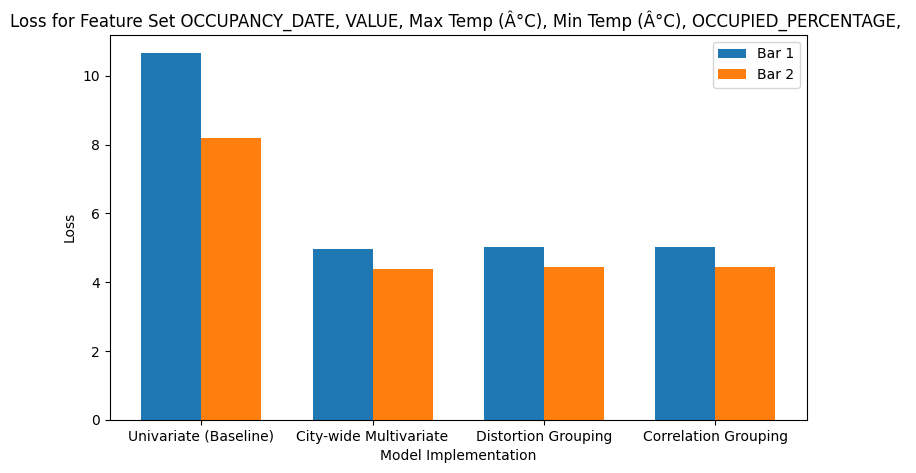




Best Set of features for Distortions: ('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Min Temp (Â°C)', 'OCCUPIED_PERCENTAGE')


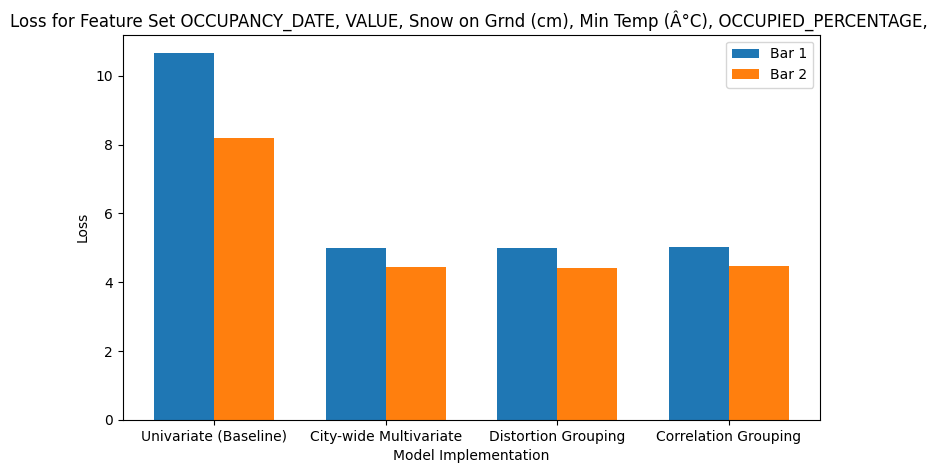




Best Set of features for Correlation: ('OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Max Temp (Â°C)', 'OCCUPIED_PERCENTAGE')


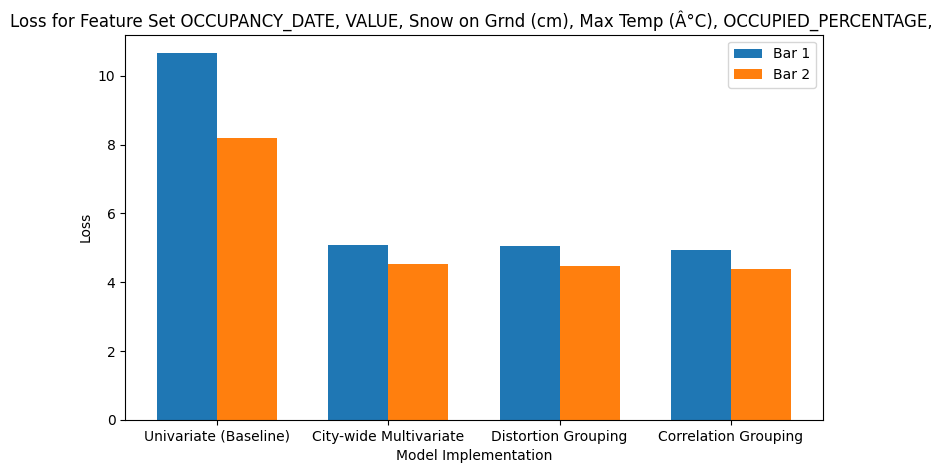

In [47]:
# Define the categories on the x-axis
categories = ['Univariate (Baseline)', 'City-wide Multivariate', 'Distortion Grouping', 'Correlation Grouping']
bar_width = 0.35

# Define the x positions for the bars
x = np.arange(len(categories))

for i in best_feat.copy():
  plt.figure(figsize=(9, 5))

  print("Best Set of features for " + str(i)+  ": " + str(best_feat[i]))
  pre_multi_step_ls = [result_map[best_feat[i]][z][0] for z in result_map[best_feat[i]]]
  pre_multi_step_ls.insert(0, 10.661561143926528)

  multi_step_ls = [result_map[best_feat[i]][z][1] for z in result_map[best_feat[i]]]
  multi_step_ls.insert(0, 8.203336997008627)

  plt.bar(x - bar_width/2, pre_multi_step_ls, bar_width, label='Bar 1')
  plt.bar(x + bar_width/2, multi_step_ls, bar_width, label='Bar 2')

  feat = ""
  for l in best_feat[i]:
    feat += str(l) + ", "

  plt.xlabel('Model Implementation')
  plt.ylabel('Loss')
  plt.title('Loss for Feature Set ' + str(feat))
  plt.xticks(x, categories)
  plt.legend()

  # Show the plot
  plt.show()

  print('\n\n')